## **Wavelet-Enhanced Deblurring Diffusion Model (WEDDM) and Saliency Map Analysis**

This section focuses on training and evaluating the **Wavelet-Enhanced Deblurring Diffusion Model (WEDDM)** on the **GS-Blur dataset** for image deblurring. The model is trained using **Mean Squared Error (MSE) loss** and optimized with **Adam optimizer**, running for **10 epochs**.

After training, we utilize **saliency maps** to interpret the model's behavior. Saliency maps highlight the most important regions in an image that contribute to the deblurring process. By analyzing these maps, we can assess whether WEDDM attends to relevant image structures, such as edges and textures, rather than noise.

The evaluation metrics include:
- **Peak Signal-to-Noise Ratio (PSNR)** – Measures reconstruction quality (higher is better).
- **Structural Similarity Index (SSIM)** – Assesses perceptual similarity between images (higher is better).
- **Learned Perceptual Image Patch Similarity (LPIPS)** – Evaluates perceptual distance between images (lower is better).

### **Key Steps:**
1. Load the **GS-Blur dataset** and preprocess images to 96×96 resolution.
2. Train the **WEDDM model** for 10 epochs.
3. Evaluate the model on validation data.
4. Generate **saliency maps** to visualize important features influencing the model’s predictions.

The saliency map visualization provides insights into **how the WEDDM model focuses on deblurring-specific regions**, enhancing the interpretability of the results.


In [2]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error
import seaborn as sns
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips  # For calculating LPIPS (Learned Perceptual Image Patch Similarity)
from rdrobust import rdrobust, rdplot  # For Regression Discontinuity Analysis


In [3]:
# Paths to the dataset (Replace with your own paths when running the notebook)
input_dir = '/Users/zhanglin/Documents/dku/2024-2025/session3/STATS 201/reflection/week2/mini/input_noise'  # Folder containing blurry images
target_dir = '/Users/zhanglin/Documents/dku/2024-2025/session3/STATS 201/reflection/week2/mini/target'      # Folder containing clean images

# Get the list of filenames in the dataset
input_files = os.listdir(input_dir)
target_files = os.listdir(target_dir)


In [4]:
# Custom Dataset Class
class BlurredImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_files = os.listdir(input_dir)
        self.target_files = os.listdir(target_dir)

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_files[idx])
        target_image_path = os.path.join(self.target_dir, self.target_files[idx])
        
        input_image = Image.open(input_image_path).convert('RGB')
        target_image = Image.open(target_image_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
        
        return input_image, target_image

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
# Load Dataset
dataset = BlurredImageDataset(input_dir, target_dir, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# Define WEDDM Model (Simplified for demonstration)
class WEDDM(nn.Module):
    def __init__(self):
        super(WEDDM, self).__init__()
        self.denoise_module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )
        self.diffusion_module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        denoised = self.denoise_module(x)
        output = self.diffusion_module(denoised)
        return output

# Initialize Model, Loss, and Optimizer
model = WEDDM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [6]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 40 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [40/80], Loss: 0.0457
Epoch [1/10], Step [80/80], Loss: 0.0284
Epoch [2/10], Step [40/80], Loss: 0.0265
Epoch [2/10], Step [80/80], Loss: 0.0148
Epoch [3/10], Step [40/80], Loss: 0.0128
Epoch [3/10], Step [80/80], Loss: 0.0186
Epoch [4/10], Step [40/80], Loss: 0.0127
Epoch [4/10], Step [80/80], Loss: 0.0147
Epoch [5/10], Step [40/80], Loss: 0.0167
Epoch [5/10], Step [80/80], Loss: 0.0113
Epoch [6/10], Step [40/80], Loss: 0.0109
Epoch [6/10], Step [80/80], Loss: 0.0120
Epoch [7/10], Step [40/80], Loss: 0.0153
Epoch [7/10], Step [80/80], Loss: 0.0103
Epoch [8/10], Step [40/80], Loss: 0.0150
Epoch [8/10], Step [80/80], Loss: 0.0138
Epoch [9/10], Step [40/80], Loss: 0.0123
Epoch [9/10], Step [80/80], Loss: 0.0116
Epoch [10/10], Step [40/80], Loss: 0.0086
Epoch [10/10], Step [80/80], Loss: 0.0096


Validation Loss: 0.0099


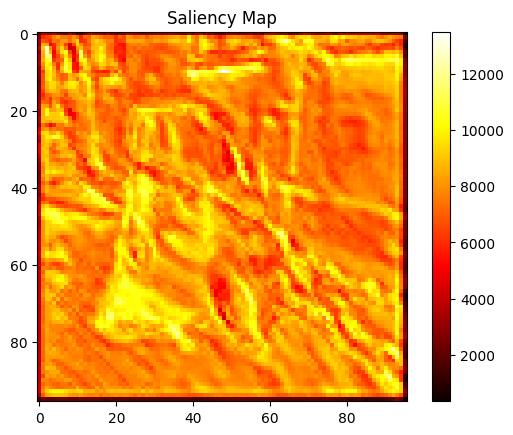

In [10]:
# Evaluation
model.eval()
val_loss = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        val_loss += criterion(outputs, targets).item()
val_loss /= len(val_loader)
print(f'Validation Loss: {val_loss:.4f}')

# Explanation: Saliency Maps
def generate_saliency_map(model, image):
    # Ensure image requires gradient
    image.requires_grad_()
    # Forward pass
    output = model(image)
    # Get the index of the maximum value along the channel dimension (dim=1)
    output_idx = output.argmax(dim=1)  # Shape: [batch_size, height, width]
    # Select the maximum value for each spatial location
    output_max = output[0, output_idx[0]].sum()  # Sum over spatial dimensions
    # Backward pass to compute gradients
    output_max.backward()
    # Get the absolute value of gradients and take the maximum along channels
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)  # Shape: [batch_size, height, width]
    return saliency

# Generate Saliency Map for a Sample Image
sample_image, _ = val_dataset[0]
sample_image = sample_image.unsqueeze(0)  # Add batch dimension
saliency_map = generate_saliency_map(model, sample_image)

# Visualize Saliency Map
plt.imshow(saliency_map.squeeze().numpy(), cmap='hot')
plt.title('Saliency Map')
plt.colorbar()
plt.show()
